# Révision 4 : modèles supervisés

<img src="https://cdn.pixabay.com/photo/2017/01/31/18/16/blackboard-2026160_960_720.png" alt="carte" width="400"/>

*Source : Image par OpenClipart-Vectors de Pixabay*

#### [Pierre-Loic BAYART](https://www.linkedin.com/in/pierreloicbayart/) - Formation développeur d'applications spécialisation data analyst - Webforce3 - Grenoble Ecole de Management

## Récupération et préparation des données

- Récupération du **dataset du Titanic** : https://raw.githubusercontent.com/Pierre-Loic/Formation-DA-GEM-2022/main/Datasets/titanic.csv

In [1]:
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/Pierre-Loic/Formation-DA-GEM-2022/main/Datasets/titanic.csv"
df = pd.read_csv(url, index_col="PassengerId", usecols=["Survived", "Pclass", "Sex", "Fare", "PassengerId", "Age"])
df

,Survived,Pclass,Sex,Age,Fare
PassengerId,,,,,
1,0,3,male,22.0,7.2500
2,1,1,female,38.0,71.2833
3,1,3,female,26.0,7.9250
4,1,1,female,35.0,53.1000
5,0,3,male,35.0,8.0500
...,...,...,...,...,...
887,0,2,male,27.0,13.0000
888,1,1,female,19.0,30.0000
889,0,3,female,NaN,23.4500


- Analyse des **données manquantes**

In [3]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
dtype: int64

## Modèles de régression

## ✏️ Exercice

**Entrainer** et **évaluer 3 modèles de régression** pour prédire le **prix des billets** connaissant le **sexe**, la **classe** et si la personne a **survécu**. Optimiser les **hyperparamètres**.

- Création des jeux de **test** et d'**entrainement**

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = df.drop("Fare", axis=1)
y = df["Fare"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape X_train : {X_train.shape}")
print(f"Shape y_train : {y_train.shape}")
print(f"Shape X_test : {X_test.shape}")
print(f"Shape y_test : {y_test.shape}")

Shape X_train : (712, 4)
Shape y_train : (712,)
Shape X_test : (179, 4)
Shape y_test : (179,)


- Création d'une liste pour les **caractéristiques numériques** et une liste pour la **caractéristique catégorielle**

In [7]:
numeric_features = ["Age", "Pclass"]
categorical_features = ["Survived", "Sex"]

- Création du **pipeline de régression linéaire**

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [9]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [10]:
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

- **Entrainement** du pipeline

In [11]:
reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Pclass']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Survived', 'Sex'])])),
                ('regressor', LinearRegression())])

- **Evaluation** du modèle

In [12]:
from sklearn.metrics import mean_absolute_error

In [13]:
print(f"R2 entrainement : {round(reg.score(X_train, y_train), 3)} - R2 test : {round(reg.score(X_test, y_test), 3)}")

R2 entrainement : 0.316 - R2 test : 0.339


In [14]:
print(f"MAE entrainement : {round(mean_absolute_error(y_train, reg.predict(X_train)), 3)} - "\
       + f"MAE test : {round(mean_absolute_error(y_test, reg.predict(X_test)), 3)}")

MAE entrainement : 21.514 - MAE test : 19.975


In [15]:
df.groupby("Pclass").mean()["Fare"]

C:\Users\PLB\AppData\Local\Temp\ipykernel_12740\1401337907.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Pclass").mean()["Fare"]


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

- **Optimisation** des modèles et des hyperparamètres

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [17]:
# Modèle 1 : decision tree
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor())]
)
param_grid = {
    "regressor__max_depth": [None, 2, 5, 10, 20],
}
search = GridSearchCV(reg, param_grid, cv=5)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_}):")
print(search.best_params_)
print(f"R2 entrainement : {round(search.best_estimator_.score(X_train, y_train), 3)} - R2 test : {round(search.best_estimator_.score(X_test, y_test), 3)}")

Best parameter (CV score=0.364761397492932):
{'regressor__max_depth': 2}
R2 entrainement : 0.389 - R2 test : 0.378


In [18]:
# Modèle 2 : random forest
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(n_jobs=-1))]
)
param_grid = {
    "regressor__n_estimators": [50, 100, 200, 500, 1000],
    "regressor__max_depth": [2, 5, 10, 100, 200, None],
}
search = GridSearchCV(reg, param_grid, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_}):")
print(search.best_params_)
print(f"R2 entrainement : {round(search.best_estimator_.score(X_train, y_train), 3)} - R2 test : {round(search.best_estimator_.score(X_test, y_test), 3)}")

Best parameter (CV score=0.4100351298935195):
{'regressor__max_depth': 2, 'regressor__n_estimators': 100}
R2 entrainement : 0.408 - R2 test : 0.354


In [19]:
print(f"MAE entrainement : {round(mean_absolute_error(y_train, search.best_estimator_.predict(X_train)), 3)} - "\
       + f"MAE test : {round(mean_absolute_error(y_test, search.best_estimator_.predict(X_test)), 3)}")

MAE entrainement : 18.177 - MAE test : 18.744


In [20]:
# Modèle 3 : gradient boosting
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", GradientBoostingRegressor())]
)
param_grid = {
    "regressor__n_estimators": [50, 100, 200, 500, 1000],
    "regressor__max_depth": [2, 3, 5],
}
search = GridSearchCV(reg, param_grid, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_}):")
print(search.best_params_)
print(f"R2 entrainement : {round(search.best_estimator_.score(X_train, y_train), 3)} - R2 test : {round(search.best_estimator_.score(X_test, y_test), 3)}")

Best parameter (CV score=0.37030157622166593):
{'regressor__max_depth': 2, 'regressor__n_estimators': 50}
R2 entrainement : 0.456 - R2 test : 0.28


In [21]:
print(f"MAE entrainement : {round(mean_absolute_error(y_train, search.best_estimator_.predict(X_train)), 3)} - "\
       + f"MAE test : {round(mean_absolute_error(y_test, search.best_estimator_.predict(X_test)), 3)}")

MAE entrainement : 17.609 - MAE test : 19.351


## Modèles de classification

## ✏️ Exercice

**Entrainer** et **évaluer 3 modèles de classification** pour prédire si la personne a survécu connaissant le **sexe**, la **classe** et le **prix** du billet. Optimiser les **hyperparamètres**.

- Création des jeux de **test** et d'**entrainement**

In [22]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape X_train : {X_train.shape}")
print(f"Shape y_train : {y_train.shape}")
print(f"Shape X_test : {X_test.shape}")
print(f"Shape y_test : {y_test.shape}")

Shape X_train : (712, 4)
Shape y_train : (712,)
Shape X_test : (179, 4)
Shape y_test : (179,)


- Création d'une liste pour les **caractéristiques numériques** et une liste pour la **caractéristique catégorielle**

In [24]:
numeric_features = ["Age", "Pclass", "Fare"]
categorical_features = ["Sex"]

- Création du **pipeline de régression logistique**

In [25]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [26]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [27]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

- **Entrainement** du modèle de classification

In [28]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Pclass', 'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex'])])),
                ('classifier', LogisticRegression())])

- **Evaluation** du modèle

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

In [30]:
def show_metrics(model):
    print(classification_report(y_test, model.predict(X_test)))
    ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test))
    plt.xticks(rotation=90)
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



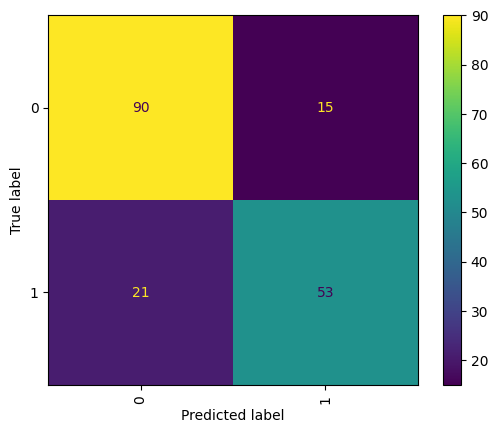

In [31]:
show_metrics(clf)

- **Optimisation** des modèles et des hyperparamètres

In [38]:
# Modèle 1 : decision tree
from sklearn.tree import DecisionTreeClassifier

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)
param_grid = {
    "classifier__max_depth": [18, 20, 25, 30, None],
}
search = GridSearchCV(clf, param_grid, cv=5)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_}):")
print(search.best_params_)

Best parameter (CV score=0.7753767359401162):
{'classifier__max_depth': 18}


              precision    recall  f1-score   support

           0       0.80      0.77      0.79       105
           1       0.69      0.73      0.71        74

    accuracy                           0.75       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.75      0.76       179



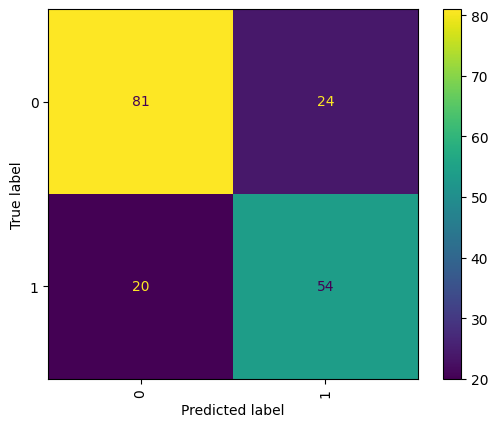

In [39]:
show_metrics(search.best_estimator_)

In [40]:
# Modèle 2 : random forest
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_jobs=-1))]
)
param_grid = {
    "classifier__max_depth": [25, 30, 50],
    "classifier__n_estimators": [100, 200, 500, 1000],
}
search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_}):")
print(search.best_params_)

Best parameter (CV score=0.8090318132571654):
{'classifier__max_depth': 50, 'classifier__n_estimators': 500}


              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



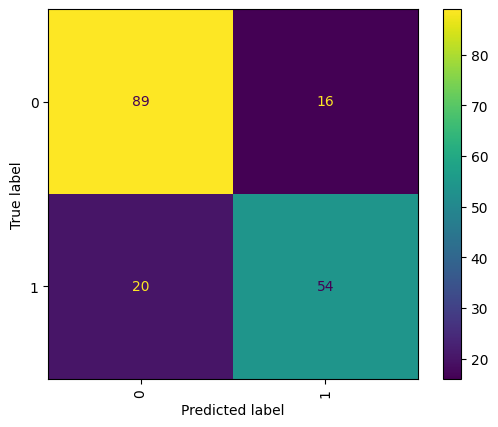

In [41]:
show_metrics(search.best_estimator_)

In [42]:
# Modèle 3 : gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingClassifier())]
)
param_grid = {
    "classifier__n_estimators": [25, 50, 100, 200, 500],
}
search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_}):")
print(search.best_params_)

Best parameter (CV score=0.8188417216586231):
{'classifier__n_estimators': 200}


              precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



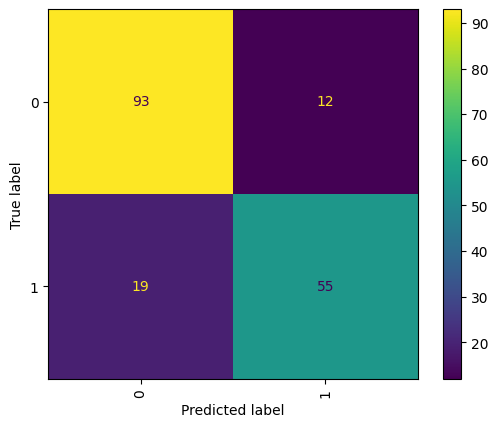

In [43]:
show_metrics(search.best_estimator_)